In [1]:
import gcsfs
import jax
import numpy as np
import pickle
import xarray

from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils

#import neuralgcm
!git clone https://github.com/mylrcd/neuralgcmPFE.git
%pip install -e neuralgcmPFE

gcs = gcsfs.GCSFileSystem(token='anon')

import warnings
warnings.filterwarnings('ignore')

fatal: destination path 'neuralgcmPFE' already exists and is not an empty directory.


Obtaining file:///C:/Users/mayeu/SynologyDrive/DossiersMayeul/Mes%20Documents/TSP/3A/PFE/NeuralGCM/quickstart/neuralgcmPFENote: you may need to restart the kernel to use updated packages.

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for neuralgcm (pyproject.toml): started
  Building editable for neuralgcm (pyproject.toml): finished with status 'done'
  Created wheel for neuralgcm: filename=neuralgcm-1.0.0-0.editable-py3-none-any.whl size=11523 sha256=d8ade5706c1000856f13e1db51da4405633197d0bcd914b2f049743dd950b209
  Stored


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import sys
sys.path.append("c:/Users/mayeu/SynologyDrive/DossiersMayeul/Mes Documents/TSP/3A/PFE/NeuralGCM/quickstart/neuralgcmPFE")

In [3]:
from neuralgcmPFE import neuralgcm

model_name = 'neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl'  #@param ['neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl', 'neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl'] {type: "string"}

with gcs.open(f'gs://gresearch/neuralgcm/04_30_2024/{model_name}', 'rb') as f:
    ckpt = pickle.load(f)

model = neuralgcm.PressureLevelModel.from_checkpoint(ckpt)

In [4]:
era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5 = xarray.open_zarr(gcs.get_mapper(era5_path), chunks=None)

demo_start_time = '2020-02-14'
demo_end_time = '2020-02-18'
data_inner_steps = 24  # process every 24th hour

sliced_era5 = (
    full_era5
    [model.input_variables + model.forcing_variables]
    .pipe(
        xarray_utils.selective_temporal_shift,
        variables=model.forcing_variables,
        time_shift='24 hours',
    )
    .sel(time=slice(demo_start_time, demo_end_time, data_inner_steps))
    .compute()
)

In [5]:
sliced_era5

<xarray.Dataset> Size: 5GB
Dimensions:                              (time: 5, level: 37, latitude: 721,
                                          longitude: 1440)
Coordinates:
  * latitude                             (latitude) float32 3kB 90.0 ... -90.0
  * level                                (level) int64 296B 1 2 3 ... 975 1000
  * longitude                            (longitude) float32 6kB 0.0 ... 359.8
  * time                                 (time) datetime64[ns] 40B 2020-02-14...
Data variables:
    geopotential                         (time, level, latitude, longitude) float32 768MB ...
    specific_humidity                    (time, level, latitude, longitude) float32 768MB ...
    temperature                          (time, level, latitude, longitude) float32 768MB ...
    u_component_of_wind                  (time, level, latitude, longitude) float32 768MB ...
    v_component_of_wind                  (time, level, latitude, longitude) float32 768MB ...
    specific_cloud_ice_water_content     (time, level, latitude, longitude) float32 768MB ...
    specific_cloud_liquid_water_content  (time, level, latitude, longitude) float32 768MB ...
    sea_ice_cover                        (time, latitude, longitude) float32 21MB ...
    sea_surface_temperature              (time, latitude, longitude) float32 21MB ...
Attributes:
    valid_time_start:  1940-01-01
    last_updated:      2025-01-12 11:54:41.741475
    valid_time_stop:   2024-10-31

In [6]:
era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5.sizes['latitude'],
    longitude_nodes=full_era5.sizes['longitude'],
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude),
)
regridder = horizontal_interpolation.ConservativeRegridder(
    era5_grid, model.data_coords.horizontal, skipna=True
)
eval_era5 = xarray_utils.regrid(sliced_era5, regridder)
eval_era5 = xarray_utils.fill_nan_with_nearest(eval_era5)

XlaRuntimeError: FAILED_PRECONDITION: Buffer Definition Event: Error dispatching computation: %sError preparing computation: %sOut of memory allocating 5259392 bytes.

In [ ]:
eval_era5

<xarray.Dataset> Size: 171MB
Dimensions:                              (level: 37, time: 5, longitude: 256,
                                          latitude: 128)
Coordinates:
  * level                                (level) int64 296B 1 2 3 ... 975 1000
  * time                                 (time) datetime64[ns] 40B 2020-02-14...
  * longitude                            (longitude) float64 2kB 0.0 ... 358.6
  * latitude                             (latitude) float64 1kB -88.93 ... 88.93
Data variables:
    geopotential                         (time, level, longitude, latitude) float32 24MB ...
    specific_humidity                    (time, level, longitude, latitude) float32 24MB ...
    temperature                          (time, level, longitude, latitude) float32 24MB ...
    u_component_of_wind                  (time, level, longitude, latitude) float32 24MB ...
    v_component_of_wind                  (time, level, longitude, latitude) float32 24MB ...
    specific_cloud_ice_water_content     (time, level, longitude, latitude) float32 24MB ...
    specific_cloud_liquid_water_content  (time, level, longitude, latitude) float32 24MB ...
    sea_ice_cover                        (time, longitude, latitude) float32 655kB ...
    sea_surface_temperature              (time, longitude, latitude) float32 655kB ...

In [ ]:
inner_steps = 24  # save model outputs once every 24 hours
outer_steps = 4 * 24 // inner_steps  # total of 4 days
timedelta = np.timedelta64(1, 'h') * inner_steps
times = (np.arange(outer_steps) * inner_steps)  # time axis in hours

# initialize model state
inputs = model.inputs_from_xarray(eval_era5.isel(time=0))
input_forcings = model.forcings_from_xarray(eval_era5.isel(time=0))
rng_key = jax.random.key(42)  # optional for deterministic models

In [18]:
input_forcings.keys()

dict_keys(['sea_ice_cover', 'sea_surface_temperature', 'sim_time'])

In [7]:
input_forcings

NameError: name 'input_forcings' is not defined

In [11]:
fseai = input_forcings['sea_ice_cover'].shape
fseas = input_forcings['sea_surface_temperature'].shape
ftime = input_forcings['sim_time'].shape

print(fseai)
print(fseas)
print(ftime)

(1, 256, 128)
(1, 256, 128)
()


In [12]:
import pandas as pd

In [13]:
geop = inputs['geopotential']
np.mean(geop)
geop[0].shape

(256, 128)

In [14]:
geo = inputs['geopotential'].shape
spe = inputs['specific_humidity'].shape
temp = inputs['temperature'].shape
u_wind = inputs['u_component_of_wind'].shape
v_wind = inputs['v_component_of_wind'].shape
time = inputs['sim_time'].shape

print(geo)
print(spe)
print(temp)
print(u_wind)
print(v_wind)
print(time)

(37, 256, 128)
(37, 256, 128)
(37, 256, 128)
(37, 256, 128)
(37, 256, 128)
()


In [15]:
inputs['geopotential'].shape[0]

37

In [16]:
results = []
dataG = inputs['specific_humidity']
for i in range(dataG.shape[0]) :
    if i % 8 == 0 :
        data = dataG[i]
        moyenne = np.mean(data)
        ecart_type = np.std(data)
        min_val = np.min(data)
        max_val = np.max(data)

        level_info = {
            "mean": np.round(moyenne, 10),
            "std": np.round(ecart_type, 10),
            "min": np.round(min_val, 10),
            "max": np.round(max_val, 10)
        }
        results.append(level_info)
results

[{'mean': 3.8344e-06, 'std': 1.564e-07, 'min': 3.0758e-06, 'max': 4.0835e-06},
 {'mean': 2.818e-06, 'std': 8.4e-08, 'min': 2.5599e-06, 'max': 3.2926e-06},
 {'mean': 6.09523e-05,
  'std': 8.11908e-05,
  'min': 3.2823e-06,
  'max': 0.0004949116},
 {'mean': 0.0018833724,
  'std': 0.0021755043,
  'min': 1.4893e-05,
  'max': 0.010320778},
 {'mean': 0.005408603,
  'std': 0.0049265353,
  'min': 6.23738e-05,
  'max': 0.017578755}]

In [27]:
inputs.keys()

dict_keys(['geopotential', 'specific_humidity', 'temperature', 'u_component_of_wind', 'v_component_of_wind', 'specific_cloud_ice_water_content', 'specific_cloud_liquid_water_content', 'sim_time'])

In [ ]:
print(len(inputs)) 

In [ ]:
initial_state = model.encode(inputs, input_forcings, rng_key)

In [ ]:
initial_state

ModelState(state=StateWithTime(vorticity=Array([[[-4.3370575e-03, -3.6791213e-02,  9.8555937e-02, ...,
          3.4284312e-10,  2.1678708e-09, -0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  2.9997644e-04, -1.2464179e-02, ...,
         -1.2015745e-09,  5.0052318e-09, -0.0000000e+00],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -8.0640983e-10, -1.4741594e-09,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  1.0122618e-09,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00, -2.0684938e-09, -0.0000000e+00]],

       [[-4.6887458e-03,  2.2260917e-03,  5.8194131e-02, ...,
          1.9967625e-09, -7.2200418e-10, -0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  

In [20]:
print(initial_state.state.vorticity.shape)

(32, 256, 129)


In [19]:
divergence_map = initial_state.state.divergence[0, :, :] 


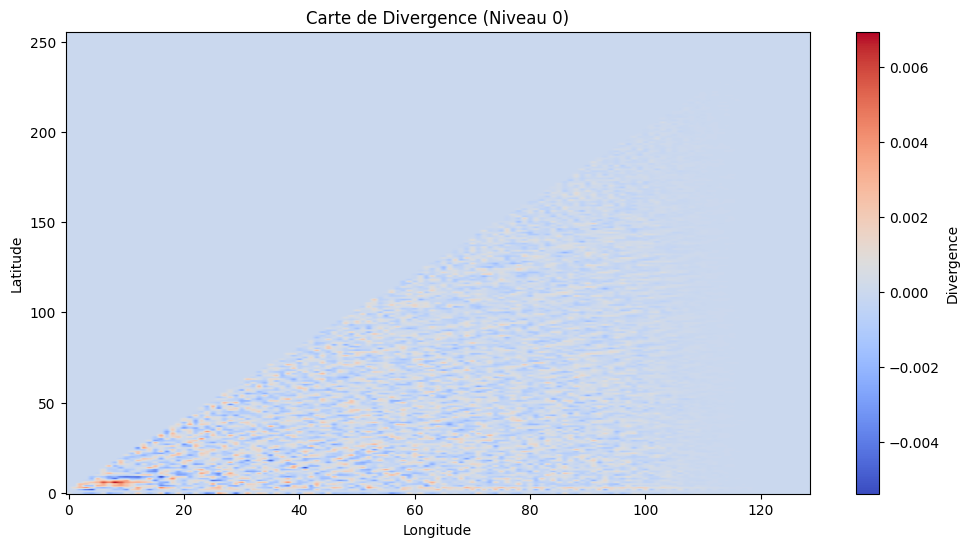

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.imshow(divergence_map, origin='lower', cmap='coolwarm', aspect='auto')
plt.colorbar(label="Divergence")
plt.title("Carte de Divergence (Niveau 0)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [8]:
# use persistence for forcing variables (SST and sea ice cover)
all_forcings = model.forcings_from_xarray(eval_era5.head(time=1))

# make forecast
final_state, predictions = model.unroll(
    initial_state,
    all_forcings,
    steps=outer_steps,
    timedelta=timedelta,
    start_with_input=True,
)
predictions_ds = model.data_to_xarray(predictions, times=times)

In [9]:
# Selecting ERA5 targets from exactly the same time slice
target_trajectory = model.inputs_from_xarray(
    eval_era5
    .thin(time=(inner_steps // data_inner_steps))
    .isel(time=slice(outer_steps))
)
target_data_ds = model.data_to_xarray(target_trajectory, times=times)

combined_ds = xarray.concat([target_data_ds, predictions_ds], 'model')
combined_ds.coords['model'] = ['ERA5', 'NeuralGCM']

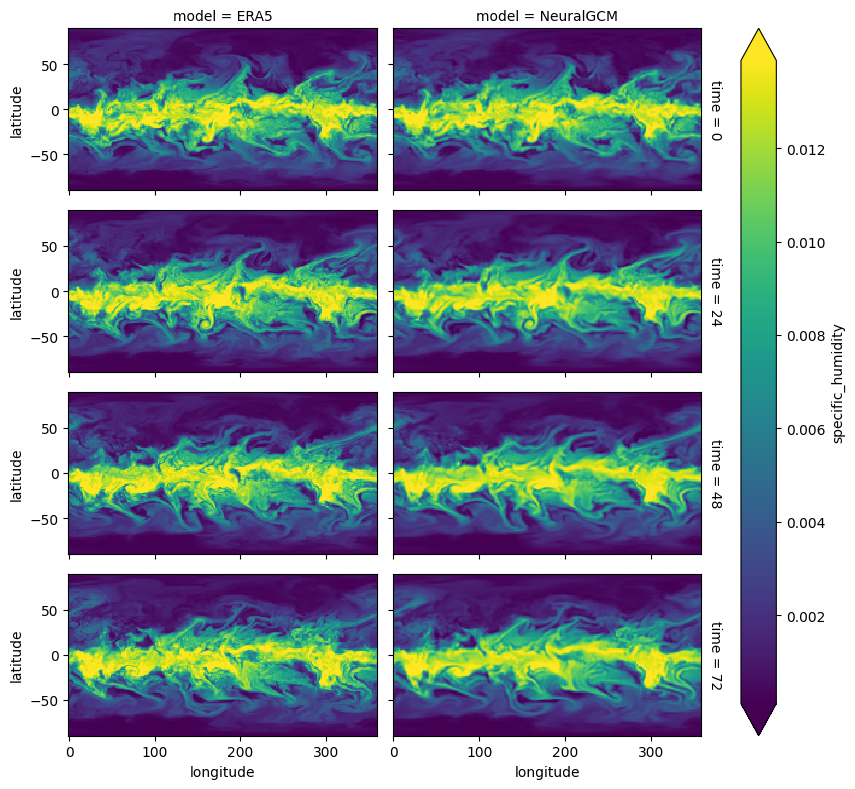

In [10]:
# Visualize ERA5 vs NeuralGCM trajectories
combined_ds.specific_humidity.sel(level=850).plot(
    x='longitude', y='latitude', row='time', col='model', robust=True, aspect=2, size=2
);